# TP : Classification d'Images avec CNN et CIFAR-10

## 🎯 Objectifs pédagogiques
- Chargement et prétraitement des données CIFAR-10 avec PyTorch
- Visualisation des données
- Construction d’un CNN
- Application de l'augmentation de données
- Régularisation pour éviter le surapprentissage
- Évaluation des performances
- Visualisation des prédictions et des erreurs

## Étape 1 : Chargement des données

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transformation: conversion en tenseur et normalisation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement des données
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = trainset.classes
print(f"Shape des images : {trainset.data.shape}")
print(f"Nombre de classes : {len(classes)}")

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Shape des images : (50000, 32, 32, 3)
Nombre de classes : 10


**Réponses aux questions :**
- Les images ont la forme `(32, 32, 3)`.
- Il y a 10 classes différentes.
- La normalisation est importante pour accélérer l'entraînement et stabiliser la descente de gradient.

## Étape 2 : Visualisation et exploration

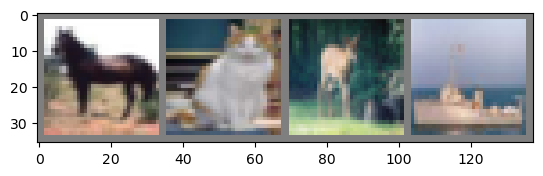

horse cat   deer  ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher des images
def imshow(img):
    img = img / 2 + 0.5     # dénormaliser
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtenir quelques images aléatoires
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Afficher les images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

**Réponses aux questions :**
- Certaines classes comme *chat* et *chien* peuvent être visuellement similaires.
- Le dataset est équilibré avec 6000 images par classe.
- La petite taille (32x32) limite la quantité de détails visuels, ce qui complique la classification.

## Étape 3 : Prétraitement des données

In [5]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset avec augmentation
trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_augmented)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=4,
                                              shuffle=True, num_workers=2)

Files already downloaded and verified


**Réponses aux questions :**
- Les augmentations appropriées incluent : Flip, Crop, ColorJitter.
- Elles aident à généraliser et à prévenir le surapprentissage.
- Les transformations doivent être cohérentes entre train et test (sauf pour les augmentations spécifiques au train).

## Étape 4 : Construction de l'architecture du réseau neuronal

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Réponses aux questions :**
- Les couches convolutionnelles extraient les caractéristiques locales.
- ReLU introduit la non-linéarité.
- Le pooling réduit la taille des données.
- Flatten transforme les tenseurs 4D en 2D pour les couches fully connected.

## Étape 5 : Entraînement du modèle avec techniques de régularisation

In [11]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CIFAR10_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement simplifié pour 1 epoch
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader_aug, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,  2000] loss: 1.896
[1,  4000] loss: 1.666
[1,  6000] loss: 1.582
[1,  8000] loss: 1.504
[1, 10000] loss: 1.460
[1, 12000] loss: 1.450


## Étape 6 : Évaluation du modèle

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Précision sur le set de test: {100 * correct / total:.2f} %')

Précision sur le set de test: 51.40 %


## Étape 7 : Visualisation des prédictions

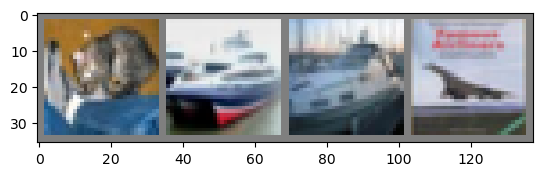

Vérités : cat   ship  ship  airplane
Prédictions : cat   ship  automobile ship 


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Affichage
imshow(torchvision.utils.make_grid(images.cpu()))
print('Vérités :', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Prédictions :', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

**Compléments théoriques :**
- `Dropout` désactive aléatoirement des neurones pendant l'entraînement pour éviter une trop forte dépendance sur certains chemins du réseau.
- `Early stopping` consiste à arrêter l'entraînement si la performance sur un ensemble de validation cesse de s'améliorer pendant plusieurs époques, évitant ainsi le surapprentissage.

## Matrice de confusion

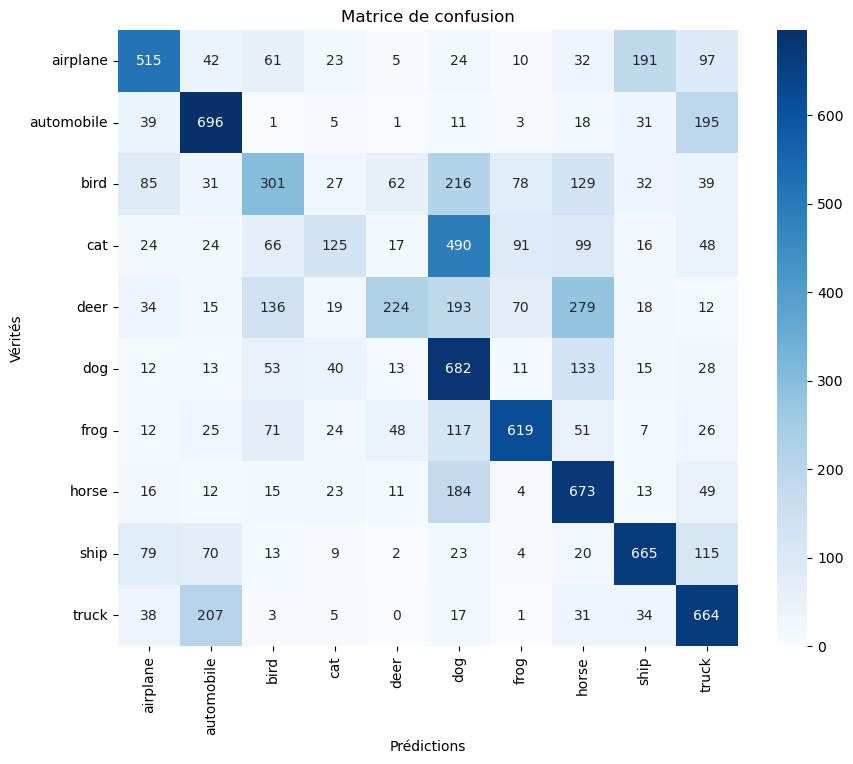

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, predicted), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()

**Analyse :**
- La matrice permet d'identifier quelles classes sont confondues fréquemment.
- Des erreurs typiques peuvent survenir entre des classes visuellement proches comme 'chat' et 'chien'.

## Suggestions d'amélioration
- Utiliser des architectures plus avancées comme ResNet ou DenseNet.
- Expérimenter avec le learning rate et les techniques de scheduler.
- Ajouter plus de données ou utiliser des techniques de transfert d'apprentissage.
- Évaluer le modèle avec des métriques complémentaires comme la précision par classe, F1-score, etc.